In [1]:
import numpy as np
import scipy.stats as scs
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from tqdm import tqdm
plt.rcParams.update({'font.size': 30})

# time-dependence

In [321]:
import pandas as pd
import numpy as np

# define the column names
cols = ['Year', 'Age', 'ASFR']

# load the data into a DataFrame, skipping the first row
df = pd.read_csv('USAasfrRR.txt', delimiter='\s+', header=None, names=cols, skiprows=1)

# convert the 'Age' column to a numeric data type
df['Age'] = pd.to_numeric(df['Age'].str.replace('-', '').str.replace('+', ''))

# convert the DataFrame to a numpy array
data = df.values
data = data[data[:,0]>2011]

C:\Users\david\AppData\Local\Temp\ipykernel_36548\1645148825.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Age'] = pd.to_numeric(df['Age'].str.replace('-', '').str.replace('+', ''))


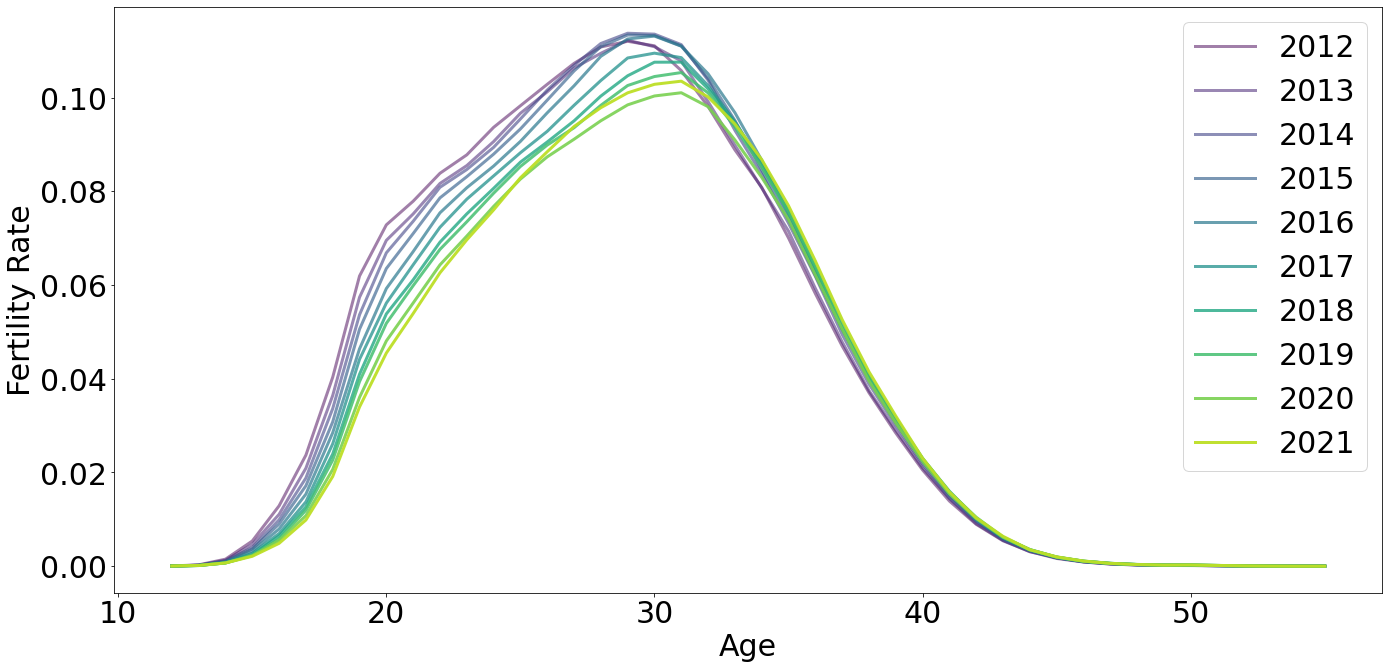

In [322]:
from matplotlib.cm import viridis
for k in range(10):
    color = viridis(k/10)
    plt.plot(range(12,56),data[k*44:44+k*44,2],color=color,label=str(k+2012),linewidth=3,alpha=0.5+k*0.05)
fig = plt.gcf() 
fig.set_size_inches(20,10)
plt.xlabel('Age')
plt.ylabel('Fertility Rate')
plt.legend()
plt.tight_layout()
plt.show()

In [323]:
# Energy Score
from scipy.spatial.distance import pdist
def Energy_Score(beta,observations_y,simulations_Y):

    n = len(observations_y)
    m = len(simulations_Y)
    observations_y = np.array(observations_y)
    simulations_Y = np.array(simulations_Y)

    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = np.power(
            np.linalg.norm(
                np.tile(observations_y,(m,1)) -
                simulations_Y,
            axis=1),
        beta)

    #Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * np.power(
        pdist(simulations_Y)
    ,beta)

    Energy = 2 * np.mean(diff_Y_y) - np.sum(diff_Y_Y)/(m*(m-1))
    return Energy


Energy_Score(1,[np.random.normal(size=50)],np.random.multivariate_normal(mean=np.zeros(50),cov=np.eye(50),size=10))

11.551607357668903

In [325]:
# mixture of gammas

def Gmix(g,a1,b1,a2,b2,size):
    sample1 = np.random.gamma(a1,b1,size=size)
    sample2 = np.random.gamma(a2,b2,size=size)
    mix = np.random.choice([0,1],p=[g,1-g], size=size,replace=True)
    return np.multiply(mix,sample1)+np.multiply(mix==False,sample2)

Gmix(0.3,20,1,20,1,10)+12

array([28.24181804, 31.34222179, 29.04646846, 30.07982604, 32.93841718,
       30.44270518, 22.72160435, 29.77996957, 34.86523584, 30.56993514])

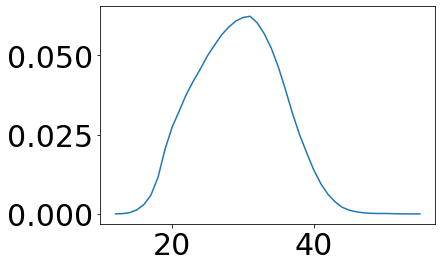

In [377]:
plt.plot(range(12,56),data[44*year:44*year+44,2]/np.sum(data[44*year:44*year+44,2]))

In [363]:
# ABC

def ABC(iter,draws_mix,draws_sr):

    out = []

    for m in tqdm(range(iter)):

        # sample initial theta
        a_1,a_2=np.random.normal(loc=2.9),np.random.normal(loc=3.1)
        theta = [[
            np.random.normal(),
            np.min([a_1,a_2]),
            np.random.normal(),
            np.max([a_1,a_2]),
            np.random.normal()
        ]]
        SR = [Energy_Score(
            1,
            np.random.choice(data[:44,1]-12,p=data[:44,2]/np.sum(data[:44,2]),size=draws_mix,replace=True),
            [Gmix(1/(1+np.exp(-theta[0][0])),np.exp(theta[0][1]),np.exp(theta[0][2]),np.exp(theta[0][3]),np.exp(theta[0][4]),draws_mix) for k in range(draws_sr)]
        )]

        # loop 9 years
        for year in range(1,10):

            # update
            theta.append([
                np.random.normal(loc=theta[year-1][0]),
                np.random.normal(loc=np.min([theta[year-1][1],theta[year-1][3]])),
                np.random.normal(loc=theta[year-1][2]),
                np.random.normal(loc=np.max([theta[year-1][1],theta[year-1][3]])),
                np.random.normal(loc=theta[year-1][4])
            ])

            # SR
            SR.append(Energy_Score(
            1,
            np.random.choice(data[44*year:44*year+44,1]-12,p=data[44*year:44*year+44,2]/np.sum(data[44*year:44*year+44,2]),size=draws_mix,replace=True),
            [Gmix(1/(1+np.exp(-theta[year][0])),np.exp(theta[year][1]),np.exp(theta[year][2]),np.exp(theta[year][3]),np.exp(theta[year][4]),draws_mix) for k in range(draws_sr)]
        ))

        # keep track
        out.append([theta,np.sum(SR)])

    return out

abc_run = np.array(ABC(iter=10000,draws_mix=1000,draws_sr=30))

100%|██████████| 10000/10000 [09:26<00:00, 17.64it/s]
C:\Users\david\AppData\Local\Temp\ipykernel_36548\3739208464.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  abc_run = np.array(ABC(iter=10000,draws_mix=1000,draws_sr=30))


In [392]:
top_percent_idx = np.argsort([abc_run[k][1] for k in range(len(abc_run))])[:1000]

In [393]:
import numpy as np


# create an empty array to store the median values
medians = np.empty((10, 5))

# iterate over each time point and quantity
for k in range(10):
    for j in range(5):
        # compute the median value for the current quantity and time point
        if j == 0:
            medians[k, j] = np.median(1 / (1 + np.exp(-np.array([abc_run[i][0][k][j] for i in top_percent_idx]).flatten())))
        else:
            medians[k, j] = np.median(np.exp(np.array([abc_run[i][0][k][j] for i in top_percent_idx]).flatten()))

# print the median values
print(medians)


[[ 0.49526354  9.92741008  0.92535958 27.55924163  0.80392598]
 [ 0.47721489 10.28728473  0.92021786 28.0326114   0.76536581]
 [ 0.49401505 10.34218425  0.89623978 28.45621579  0.75114987]
 [ 0.47095563 10.22841361  0.87123576 28.40985466  0.77755556]
 [ 0.49502379  9.9783327   0.89405983 28.32998873  0.78220012]
 [ 0.50029548 10.29743346  0.89025982 28.83276995  0.8341813 ]
 [ 0.48748378 10.1957783   0.90594476 28.72589166  0.78492182]
 [ 0.49547021  9.92516266  0.89136332 28.06496859  0.84503581]
 [ 0.46528403 10.05813128  0.92748563 29.96559588  0.79720624]
 [ 0.49082891 10.22364871  0.89940181 28.45231081  0.80930147]]


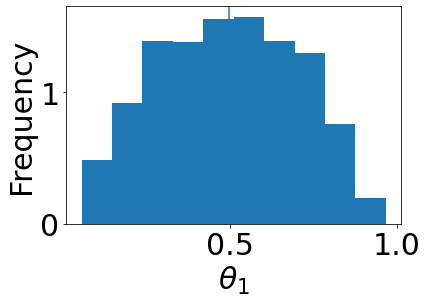

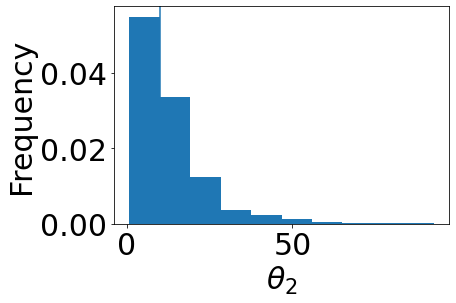

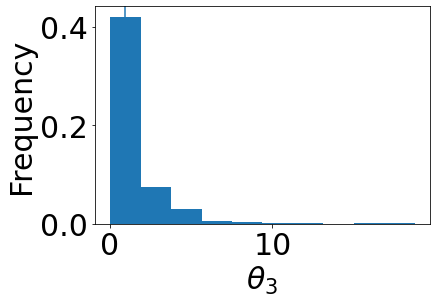

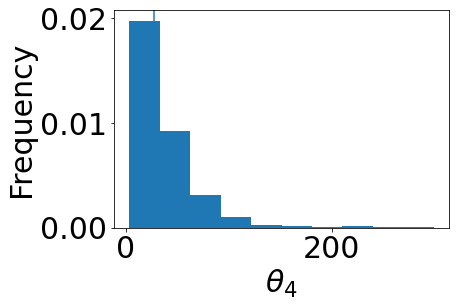

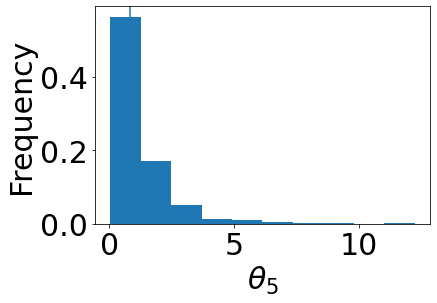

In [394]:
for k in range(1):
    # mixture param
    plt.hist(1/(1+np.exp(-np.array([abc_run[i][0][k][0]  for i in top_percent_idx]).flatten())),density=True)
    plt.axvline(medians[k,0])
    plt.xlabel(r'$\theta_1$')
    plt.ylabel('Frequency')
    plt.show()

    # a1 param
    plt.hist(np.exp(np.array([abc_run[i][0][k][1]  for i in top_percent_idx]).flatten()),density=True)
    plt.xlabel(r'$\theta_2$')
    plt.ylabel('Frequency')
    plt.axvline(medians[k,1])
    plt.show()

    # b1 param
    plt.hist(np.exp(np.array([abc_run[i][0][k][2]  for i in top_percent_idx]).flatten()),density=True)
    plt.xlabel(r'$\theta_3$')
    plt.ylabel('Frequency')
    plt.axvline(medians[k,2])
    plt.show()

    # a2 param
    plt.hist(np.exp(np.array([abc_run[i][0][k][3]  for i in top_percent_idx]).flatten()),density=True)
    plt.xlabel(r'$\theta_4$')
    plt.ylabel('Frequency')
    plt.axvline(medians[k,3])
    plt.show()

    # b2 param
    plt.hist(np.exp(np.array([abc_run[i][0][k][4]  for i in top_percent_idx]).flatten()),density=True)
    plt.xlabel(r'$\theta_5$')
    plt.axvline(medians[k,4])
    plt.ylabel('Frequency')
    plt.show()

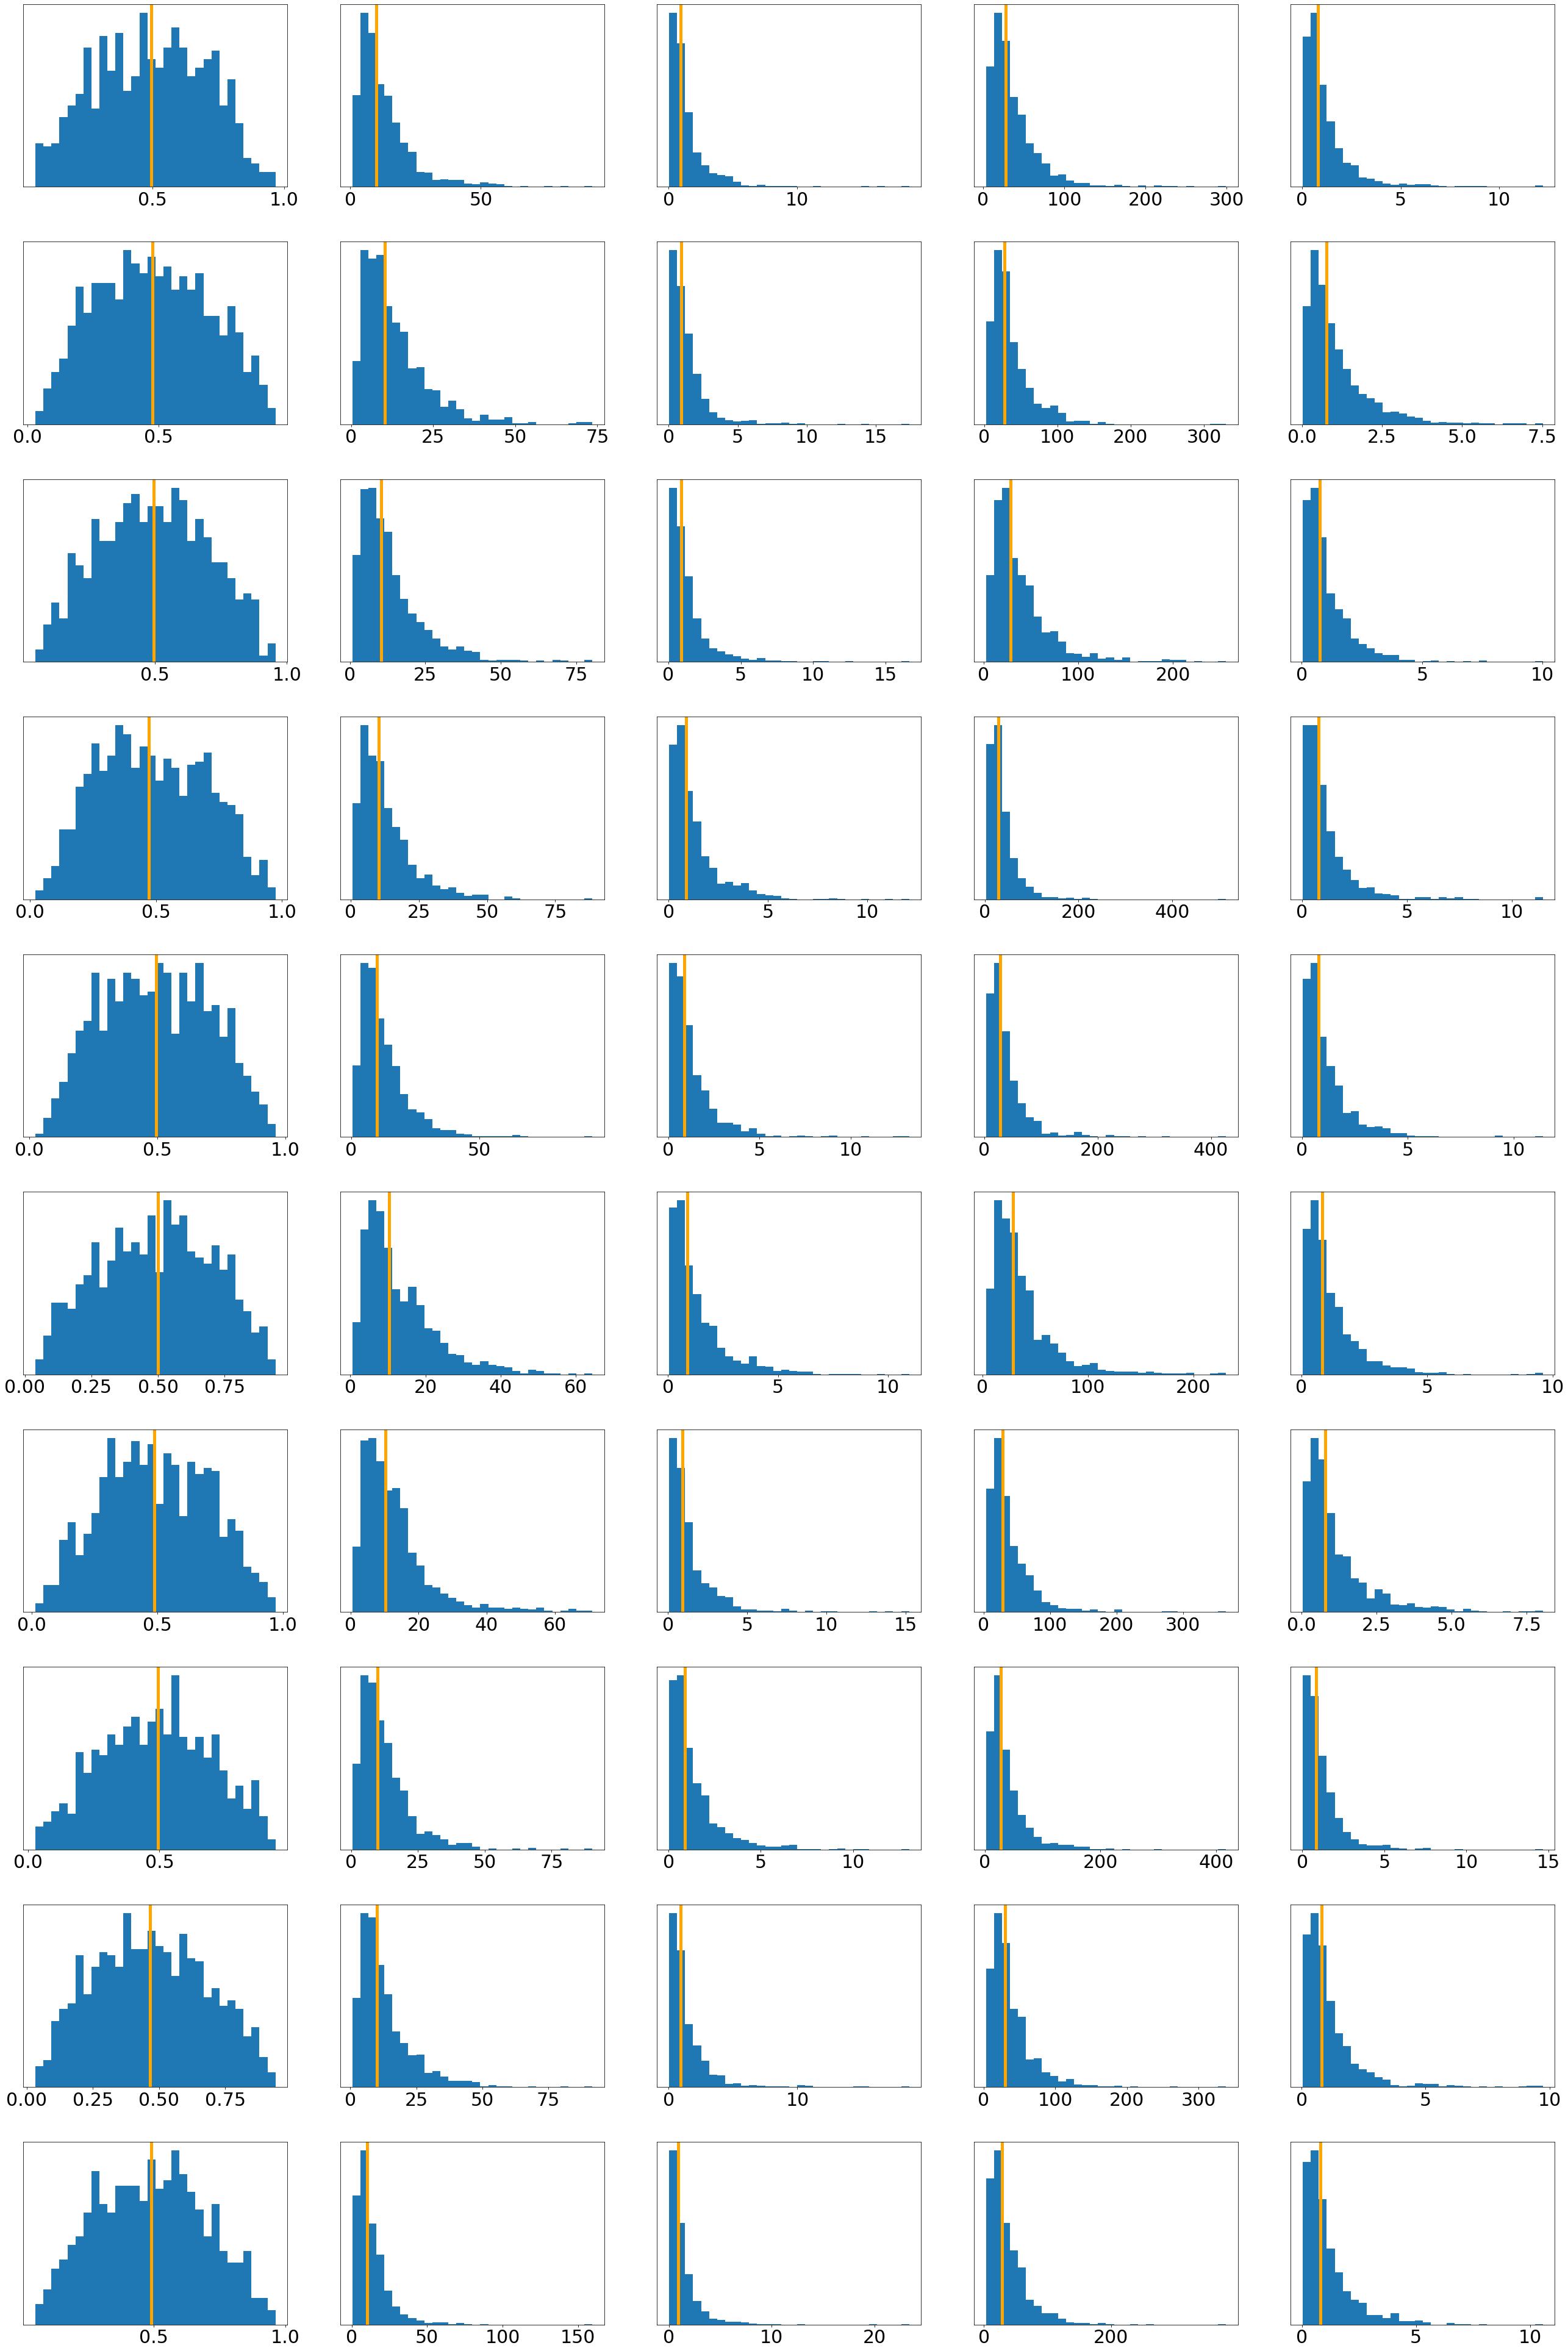

In [395]:
import numpy as np
import matplotlib.pyplot as plt

# create a grid of subplots with 10 rows and 5 columns
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(45, 70))

# iterate over each row and column of the grid
for k in range(10):
    for j in range(5):
        # plot a histogram in each subplot
        if j ==0:
            axes[k, j].hist(1/(1+np.exp(-np.array([abc_run[i][0][k][j]  for i in top_percent_idx]).flatten())), density=True,bins=30)
            median = np.median(1/(1+np.exp(-np.array([abc_run[i][0][k][j]  for i in top_percent_idx]).flatten())))
            axes[k, j].axvline(x=median, color='orange',linewidth=5)
        else:
            axes[k, j].hist(np.exp(np.array([abc_run[i][0][k][j]  for i in top_percent_idx]).flatten()), density=True,bins=30)
            median = np.median(np.exp(np.array([abc_run[i][0][k][j]  for i in top_percent_idx]).flatten()))
            axes[k, j].axvline(x=median, color='orange',linewidth=5)
        # add a vertical line for the median
        
        axes[k, j].set_yticks([])


# increase the size of each subplot
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plt.show()


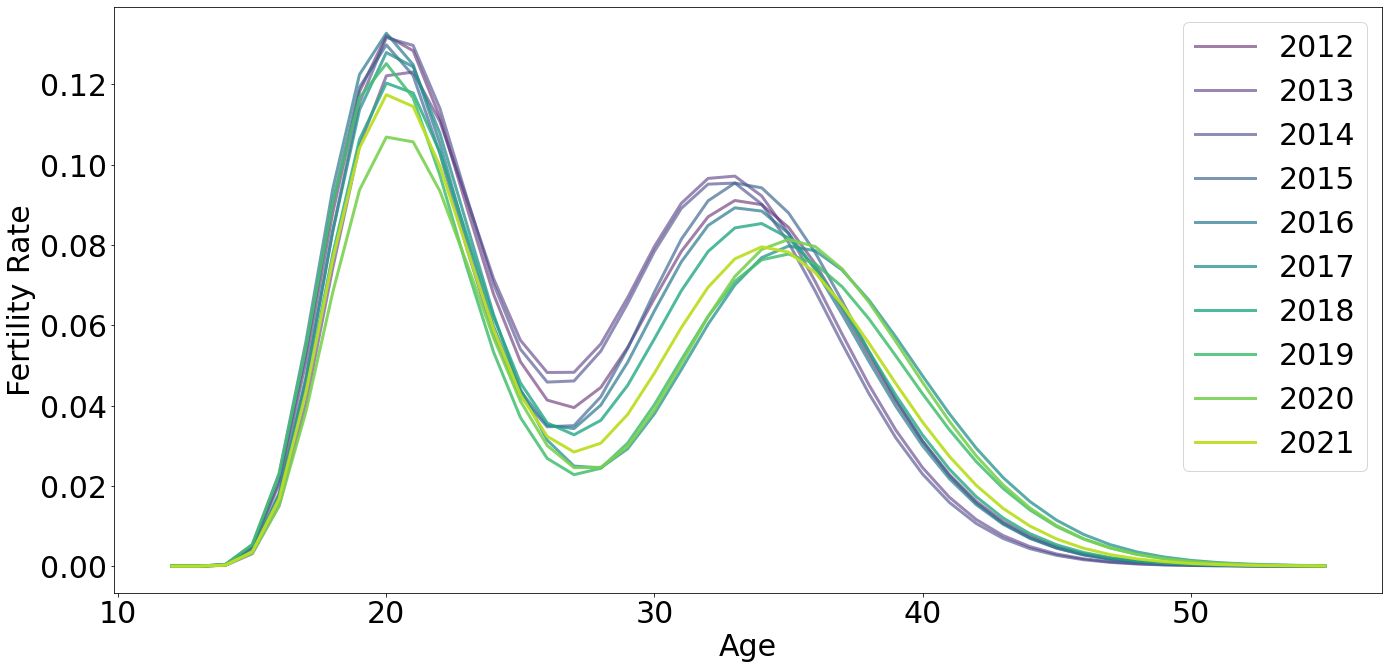

In [396]:
#Gmix_eval
from scipy.stats import gamma

def Gmix_eval(g, a1, b1, a2, b2, x):
    return g * gamma.pdf(x, a=a1, scale=b1) + (1-g) * gamma.pdf(x, a=a2, scale=b2)  

for k in range(10):
    color = viridis(k/10)
    plt.plot(range(12,56),[np.sum(data[44*k:44*k+44,2]) * Gmix_eval(
        np.median(1/(1+np.exp(-np.array([abc_run[i][0][k][0]  for i in top_percent_idx])).flatten())),
        np.median(np.exp(np.array([abc_run[i][0][k][1]  for i in top_percent_idx]).flatten())),
        np.median(np.exp(np.array([abc_run[i][0][k][2]  for i in top_percent_idx]).flatten())),
        np.median(np.exp(np.array([abc_run[i][0][k][3]  for i in top_percent_idx]).flatten())),
        np.median(np.exp(np.array([abc_run[i][0][k][4]  for i in top_percent_idx]).flatten())),
       x) for x in range(0,44)],color=color,label=str(k+2012),linewidth=3,alpha=0.5+k*0.05)
fig = plt.gcf() 
fig.set_size_inches(20,10)
plt.xlabel('Age')
plt.ylabel('Fertility Rate')
plt.legend()
plt.tight_layout()
plt.show()

#  no time-dependence

In [450]:
# ABC

def ABC(iter,draws_mix,draws_sr):

    out = []

    for m in tqdm(range(iter)):

        # sample initial theta
        a_1,a_2=np.random.normal(loc=3,scale=2),np.random.normal(loc=3,scale=2)
        theta = [[
            np.random.normal(scale=1),
            np.min([a_1,a_2]),
            np.random.normal(scale=1),
            np.max([a_1,a_2]),
            np.random.normal(scale=1)
        ]]
        SR = [Energy_Score(
            1,
            np.random.choice(data[:44,1]-12,p=data[:44,2]/np.sum(data[:44,2]),size=draws_mix,replace=True),
            [Gmix(1/(1+np.exp(-theta[0][0])),np.exp(theta[0][1]),np.exp(theta[0][2]),np.exp(theta[0][3]),np.exp(theta[0][4]),draws_mix) for k in range(draws_sr)]
        )]

        # loop 9 years
        for year in range(1,10):

            # update
            a_1,a_2=np.random.normal(loc=3,scale=2),np.random.normal(loc=3,scale=2)
            theta.append([
            np.random.normal(scale=1),
            np.min([a_1,a_2]),
            np.random.normal(scale=1),
            np.max([a_1,a_2]),
            np.random.normal(scale=1)
        ])

            # SR
            SR.append(Energy_Score(
            1,
            np.random.choice(data[0:44,1]-12,p=data[44*year:44*year+44,2]/np.sum(data[44*year:44*year+44,2]),size=draws_mix,replace=True),
            [Gmix(1/(1+np.exp(-theta[year][0])),np.exp(theta[year][1]),np.exp(theta[year][2]),np.exp(theta[year][3]),np.exp(theta[year][4]),draws_mix) for k in range(draws_sr)]
        ))

        # keep track
        out.append([theta,np.sum(SR)])

    return out

abc_run = np.array(ABC(iter=10000,draws_mix=100,draws_sr=10))

100%|██████████| 10000/10000 [01:18<00:00, 127.30it/s]
C:\Users\david\AppData\Local\Temp\ipykernel_36548\1062464543.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  abc_run = np.array(ABC(iter=10000,draws_mix=100,draws_sr=10))


In [455]:
top_percent_idx = np.argsort([abc_run[k][1] for k in range(len(abc_run))])[:1000]

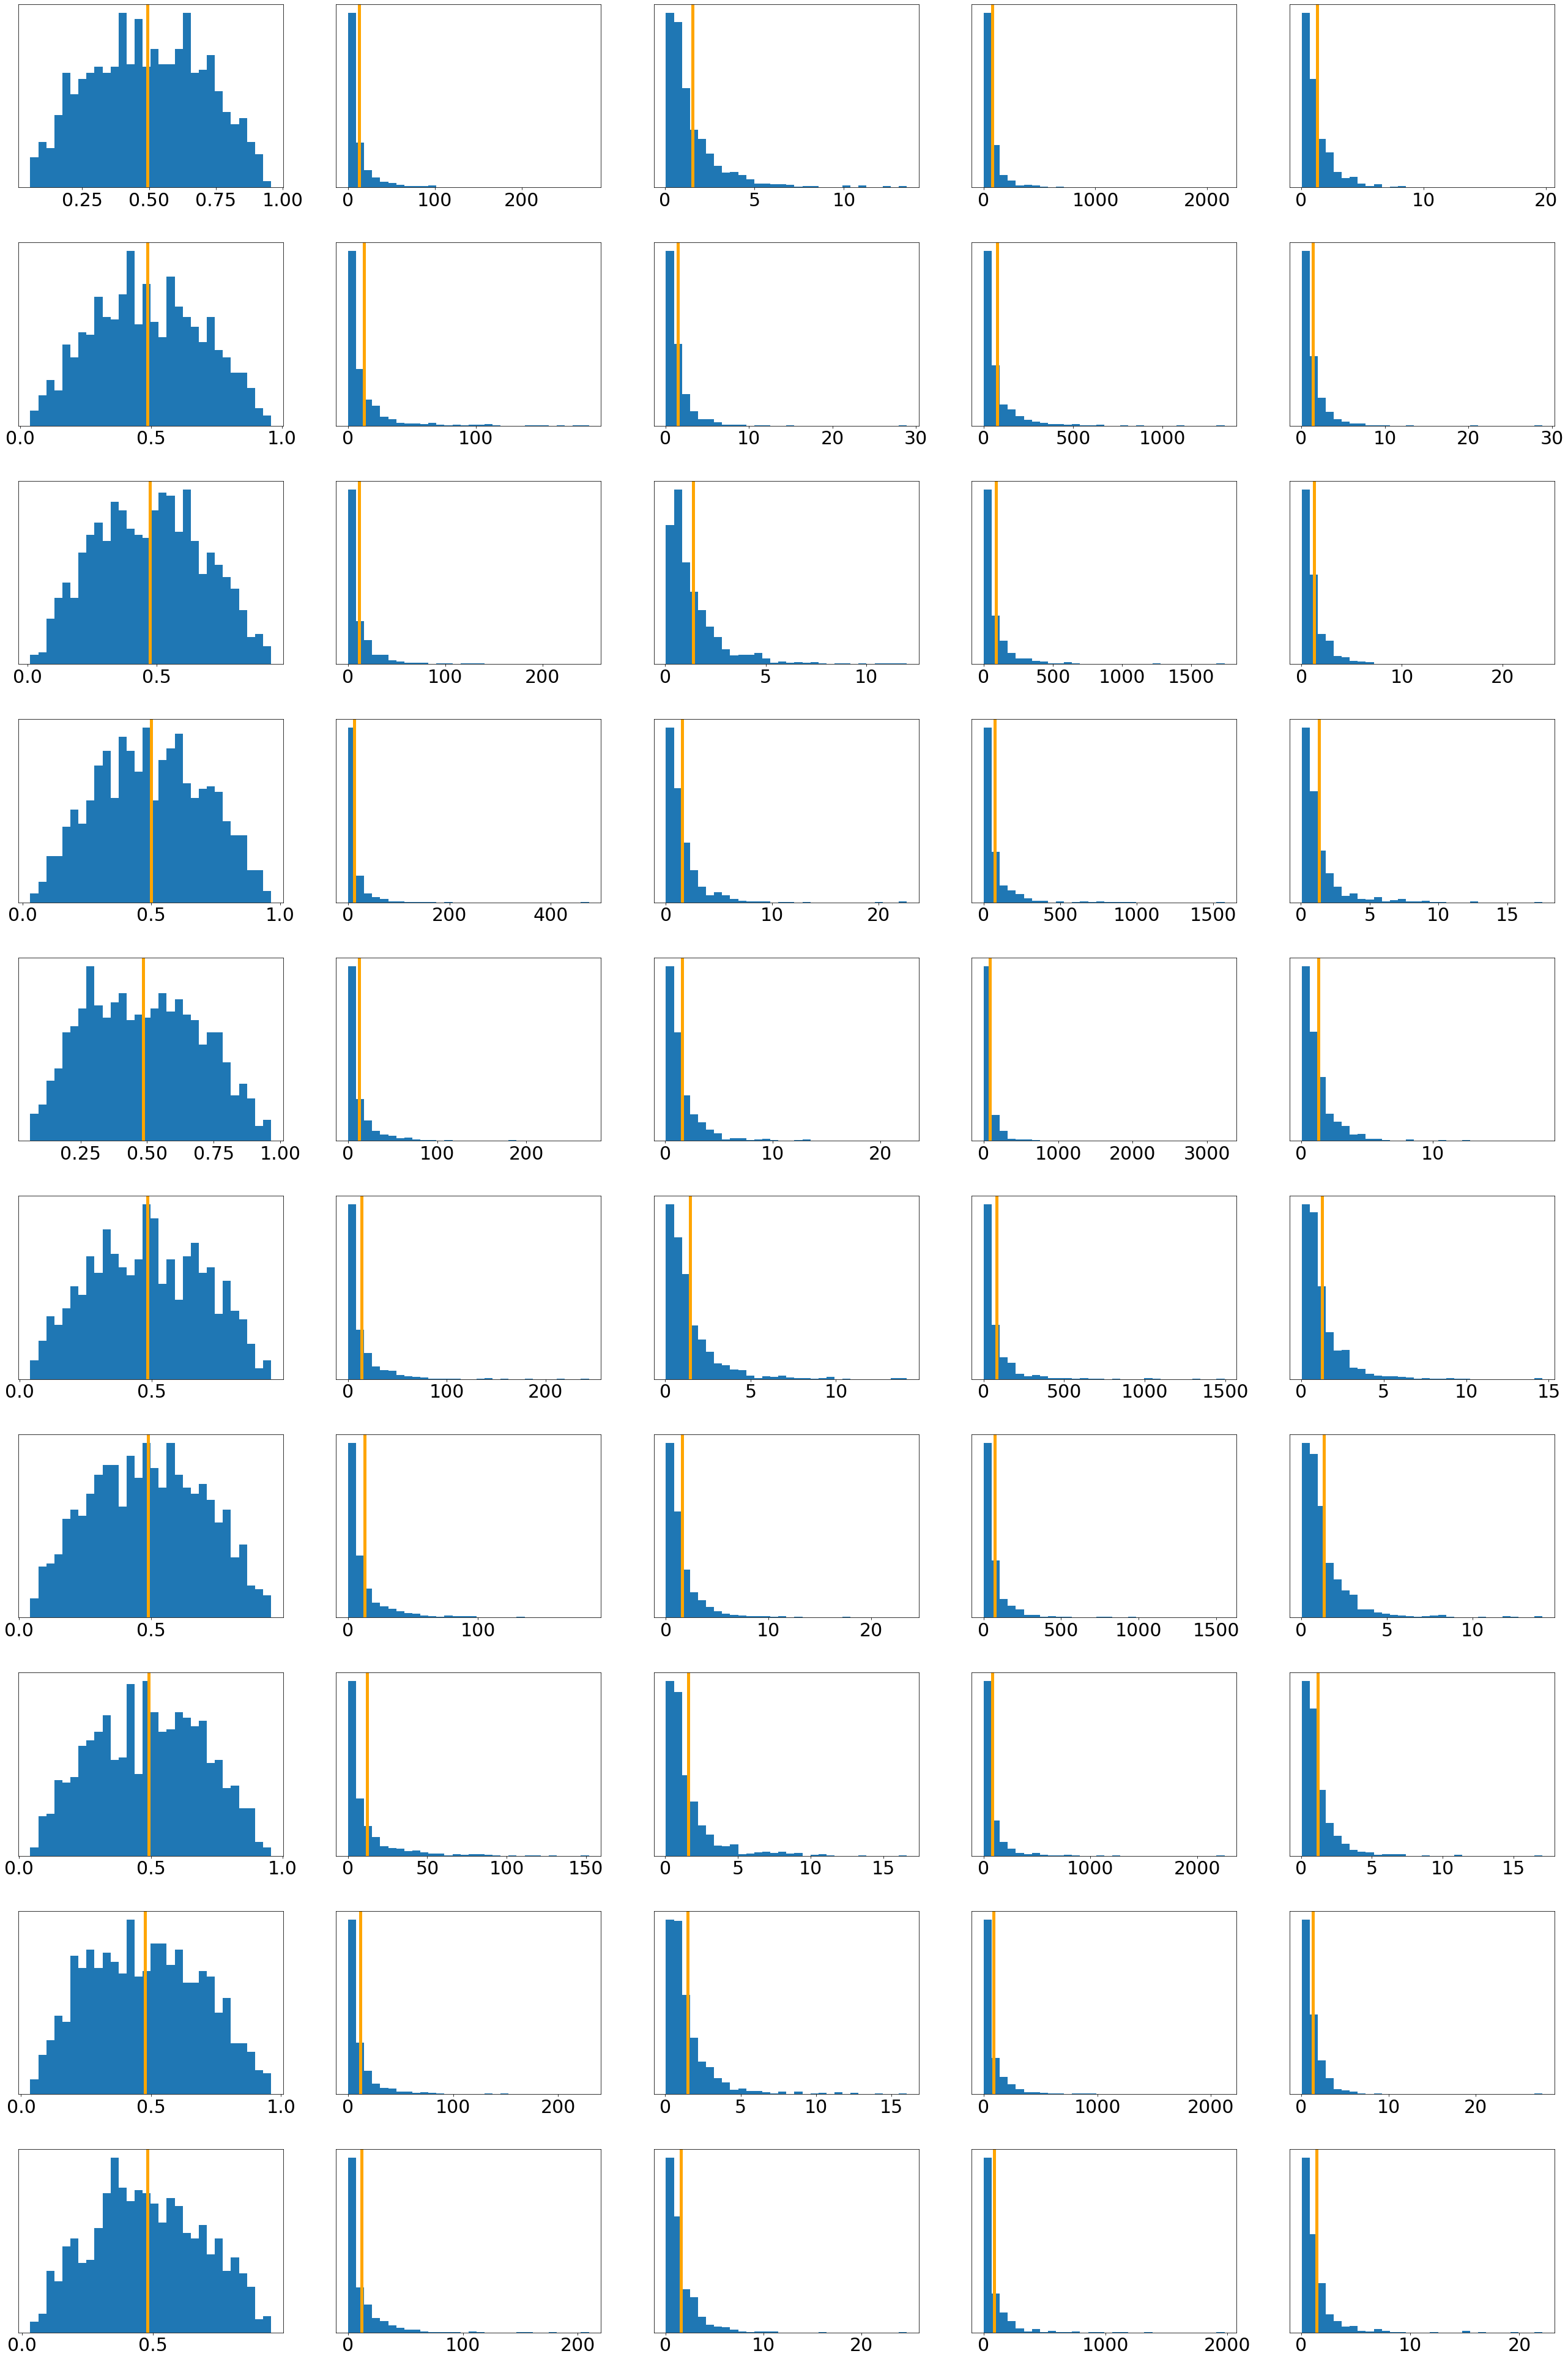

In [456]:
import numpy as np
import matplotlib.pyplot as plt

# create a grid of subplots with 10 rows and 5 columns
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(45, 70))

# iterate over each row and column of the grid
for k in range(10):
    for j in range(5):
        # plot a histogram in each subplot
        if j ==0:
            axes[k, j].hist(1/(1+np.exp(-np.array([abc_run[i][0][k][j]  for i in top_percent_idx]).flatten())), density=True,bins=30)
            mean = np.mean(1/(1+np.exp(-np.array([abc_run[i][0][k][j]  for i in top_percent_idx]).flatten())))
            axes[k, j].axvline(x=mean, color='orange',linewidth=5)
        else:
            axes[k, j].hist(np.exp(np.array([abc_run[i][0][k][j]  for i in top_percent_idx]).flatten()), density=True,bins=30)
            mean = np.mean(np.exp(np.array([abc_run[i][0][k][j]  for i in top_percent_idx]).flatten()))
            axes[k, j].axvline(x=mean, color='orange',linewidth=5)
        # add a vertical line for the median
        
        axes[k, j].set_yticks([])


# increase the size of each subplot
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plt.show()


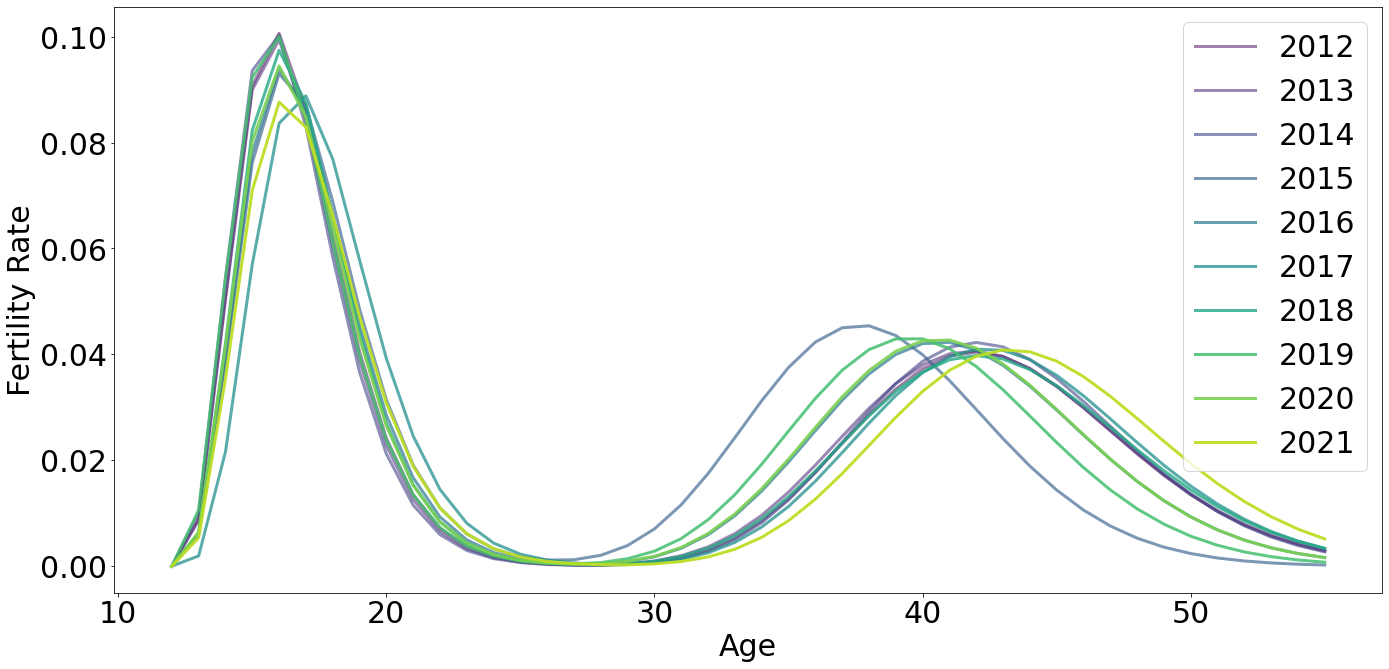

In [459]:
#Gmix_eval
from scipy.stats import gamma

def Gmix_eval(g, a1, b1, a2, b2, x):
    return g * gamma.pdf(x, a=a1, scale=b1) + (1-g) * gamma.pdf(x, a=a2, scale=b2)  

for k in range(10):
    color = viridis(k/10)
    plt.plot(range(12,56),[np.sum(data[44*k:44*k+44,2]) * Gmix_eval(
        np.median(1/(1+np.exp(-np.array([abc_run[i][0][k][0]  for i in top_percent_idx])).flatten())),
        np.median(np.exp(np.array([abc_run[i][0][k][1]  for i in top_percent_idx]).flatten())),
        np.median(np.exp(np.array([abc_run[i][0][k][2]  for i in top_percent_idx]).flatten())),
        np.median(np.exp(np.array([abc_run[i][0][k][3]  for i in top_percent_idx]).flatten())),
        np.median(np.exp(np.array([abc_run[i][0][k][4]  for i in top_percent_idx]).flatten())),
       x) for x in range(0,44)],color=color,label=str(k+2012),linewidth=3,alpha=0.5+k*0.05)
fig = plt.gcf() 
fig.set_size_inches(20,10)
plt.xlabel('Age')
plt.ylabel('Fertility Rate')
plt.legend()
plt.tight_layout()
plt.show()